In [35]:
from magpi.prelude import *
from magpi.integrate import gauss, integrate, integrate_sphere
from magpi.calc import *
from magpi.opt import TR
import matplotlib.pyplot as plt
from magpi import r_fun
from magpi.domain import Hypercube
from scipy.stats.qmc import Halton, Sobol
from magpi.surface_integral import charge_tensor, source_tensor, single_layer_potential, curl_single_layer_potential, integrate_surface, scalar_potential_charge, vector_potential_charge
import matplotlib
# matplotlib.rc('text', usetex=True)
# matplotlib.rcParams['text.latex.preamble']=r"\usepackage{amsmath}"
%matplotlib widget
jax.config.update("jax_enable_x64", False)

# Self-Energy computation with ELMs on a cubic domain

This notebook shows how to compute the self-energy of a cube with different magnetizations - in particular for a flower state and a vortex state - using 
either the scalar or vector potential.

In the first step, the magnetizations are defined. We use a centered cube $[-0.5, 0.5]^3$ as our geometry.

In [36]:
unit_vec = lambda x: x / norm(x, axis=-1, keepdims=True)
def m_vortex(x):
    x, y, z = x[..., 0], x[..., 1], x[..., 2]
    rc = 0.14
    r = sqrt(z ** 2 + x ** 2)
    k = r**2 / rc**2

    my = exp(-2 * k)
    mx = - z / r * sqrt(1 - exp(-4 * k))
    mz = x / r * sqrt(1 - exp(-4 * k))

    mag = stack([mx, my, mz], axis=-1)
    return unit_vec(mag)

def m_flower(x):
    mx = x[..., 0] * x[..., 2]
    my = x[..., 1] * x[..., 2] + (1 / 2 * x[..., 1] * x[..., 2]) ** 3
    mz = ones_like(my)
    mag = stack([mx, my, mz], axis=-1)
    return unit_vec(mag)

def m_uniform(x):
    return zeros_like(x).at[..., -1].set(1.0)

Afterwards we need a parametrization for the surface of the cube which is used for the computation of the single layer potential.
Each face of the cube has its own parametrization. The computation for each surface can then be concatenated later on. 
The `parametrization` function simply takes a point from the parametrization domain $[0, 1]^2$ and maps it onto the surface `i`. 

Afterwards the collocation points and validation points are created using a Halton Sequence. Other quasi random sequences might also be used.

In [37]:
lb, ub = -0.5, 0.5
cube = Hypercube((lb,lb,lb), (ub, ub, ub))

@partial(jit, static_argnames=("i",))
def parametrization(x, i):
    assert 0 <= i and i <= 5
    assert x.shape[-1] == 2
    if i <= 2:
        c = 0.0
        d = i
    else:
        c = 1.0
        d = i % 3
    return cube.transform(jnp.insert(x, d, c, axis=-1))

adf = r_fun.cube(ub - lb, centering=True)
X = array(Halton(3, seed=0).random(2 ** 12))
X = cube.transform(X)

X_val = array(Halton(3, seed=23126).random(2 ** 13))
X_val = cube.transform(X_val)

We use a second Taylor expansion to compute the single layer potential. Each face of the is subdivided and the expansion is done around the 
center points. This allows for precomputation of the source Tensor for each collocation point which would otherwise be expensive during runtime.
For $N$ collocation points and K segments of the surface, computation of the single layer potential has a complexity of $\mathcal{O}(NK)$. However 
parallel computing allows for very fast evaluation.

In [38]:
# Each face is subdivided into 6x6 segments
k = 7
u = jnp.linspace(0, 1, k)
v = jnp.linspace(0, 1, k)

@jit
def compute_source(x):
    _z = [source_tensor(x, lambda x: parametrization(x, i), u, v, method=gauss(10), compute_jacfwd=True) for i in range(6)]
    z, dz = zip(*_z)
    return jnp.concatenate(list(z), axis=0), jnp.concatenate(list(dz), axis=0)



@partial(jit, static_argnames=("f",))    
def compute_charge(f, *args, **kwargs):
    _c = [charge_tensor(f, lambda x: parametrization(x, i), u, v, *args, order=2, **kwargs) for i in range(6)]
    return jnp.concatenate(_c, axis=0)


adf = r_fun.cube(ub - lb, centering=True)

X = array(Halton(3, seed=0).random(2 ** 12))
X = cube.transform(X)
# source tensor of X collocation points is not required since it is only used for ph1_1

X_val = array(Halton(3, seed=23126).random(2 ** 13))
X_val = cube.transform(X_val)

# lax.map is used instead of vmap to reduce memory. This is OK since it is a preprocessing step
Z_val, dZ_val = lax.map(compute_source, X_val)

Next we crate a function to solve the scalar potential for the flower state. `solve_scalar_pot` takes random ELM weights and computes $\phi_1$ and the respective charge tensorm for $\phi_2$.

We use Monte Carlo integration to compute the self-energy. To this end, the integrand needs the collocation point as well as the respective source thensor and the gradient of this source tensor.
The gradient of the source tensor is required to compute the gradient of $\phi_2$ which is the second part of the stray field. The gradient of $\phi_1$ can simply be computed with
AD on the fly. Further, not only the self-energy is computed, but also the lower bound of the self energy (see Section 4.4 in Paper).

In [39]:
mag = m_flower

def solve_scalar_pot(W_elm, b_elm):
    h_elm = lambda x: nn.tanh(W_elm @ x) + b_elm
    u_elm = lambda x: h_elm(x) * adf(x)
    Q_phi1 = vmap(lambda x: -laplace(u_elm)(x))(X)
    U_phi1, S_phi1, VT_phi1 = jax.scipy.linalg.svd(
        Q_phi1, full_matrices=False, lapack_driver="gesvd"
    )

    S_phi1_inv = S_phi1 / (S_phi1 ** 2 + 1e-3)  # use ridge regularization with alpha=1e-3
    Pinv_phi1 = VT_phi1.T * S_phi1_inv @ U_phi1.T
    b1 = vmap(lambda x: -divergence(mag)(x))(X)
    params_phi1 = Pinv_phi1 @ b1
    phi1 = lambda x: u_elm(x) @ params_phi1
    phi1_without_adf = lambda x: h_elm(x) @ params_phi1
        
    g = scalar_potential_charge(adf, mag, phi1_without_adf, normalized=True)
    c = compute_charge(g, params_mag=(), params_phi1=())

    return phi1, c


# The single_layer_potential computes the single layer potential but can also
# compute the gradient of it since both is done by tensordot.
_slp = jit(single_layer_potential)

def integrand(x_z_dz, phi1, c):
    x, z, dz = x_z_dz
    m = mag(x)
    div_m = divergence(mag)(x)
    _phi2, _Jphi2 = _slp(z, c), _slp(dz, c)
    _Jphi1 = jacfwd(phi1)(x)
    h = - (_Jphi1 + _Jphi2)
    _lower_bound = -jnp.sum(_Jphi1 * _Jphi1) + 2 * m @ (_Jphi1 + _Jphi2) - (div_m * _phi2 + m @ _Jphi2 - laplace(phi1)(x) * _phi2)

    return -1 / 2 * mag(x) @ h, 1 / 2 * _lower_bound


def mc_integrate(f, X, *args, **kwargs):
    return tree_map(partial(mean, axis=0), vmap(lambda x: f(x, *args, *kwargs))(X))



# from magpi.integrate import integrate, gauss

# xs = jnp.linspace(-0.5, 0.5, 11)

@partial(jit, static_argnames=("phi1",))
def energy_and_lower_bound(phi1, c):
    return mc_integrate(integrand, (X_val, Z_val, dZ_val), phi1, c)
    #return integrate(integrand, [xs, xs, xs], mag, phi1, phi2, method=gauss(3))

In [40]:
e_true = 0.1528  # computed by demagnetization tensor method

energies_phi = []
lower_bounds = []
for i in range(3, 11):
    _weights = array(Halton(4, seed=42).random(2 ** i))
    W_elm = (_weights[:, :3] * 2 - 1) * 2# * 1
    b_elm = (_weights[:, 3] * 2 - 1) * 2# * 1
    phi1, c = solve_scalar_pot(W_elm, b_elm)
    e, l = energy_and_lower_bound(phi1, c)
    error = jnp.abs(e - e_true)
    energies_phi.append(e)
    lower_bounds.append(l)
    print(f"Number of basis functions {2 ** i}, energy: {e}, lower bound: {l}, error: {error}")

Number of basis functions 8, energy: 0.15977871417999268, lower bound: 0.15141454339027405, error: 0.006978720426559448
Number of basis functions 16, energy: 0.1552332639694214, lower bound: 0.1523025631904602, error: 0.002433270215988159
Number of basis functions 32, energy: 0.1536829173564911, lower bound: 0.1524655520915985, error: 0.0008829236030578613
Number of basis functions 64, energy: 0.15305036306381226, lower bound: 0.1525176763534546, error: 0.0002503693103790283
Number of basis functions 128, energy: 0.15272054076194763, lower bound: 0.1525363028049469, error: 7.94529914855957e-05
Number of basis functions 256, energy: 0.15264582633972168, lower bound: 0.152530699968338, error: 0.00015416741371154785
Number of basis functions 512, energy: 0.152593195438385, lower bound: 0.1525288224220276, error: 0.00020679831504821777
Number of basis functions 1024, energy: 0.15256208181381226, lower bound: 0.15252900123596191, error: 0.00023791193962097168


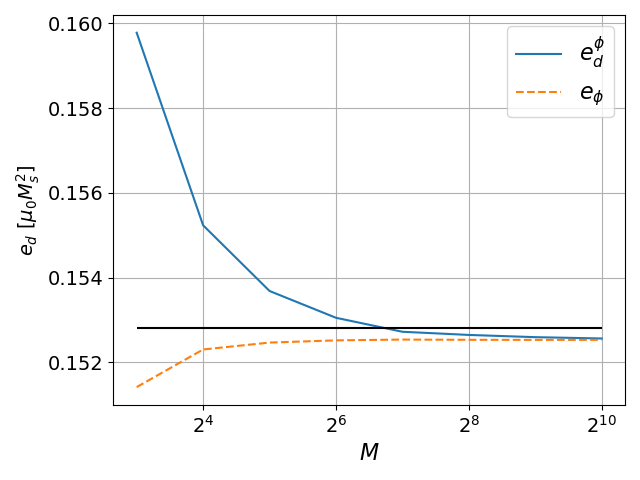

In [41]:
fig = plt.figure()
plt.plot([2 ** i for i in range(3, 11)][:len(energies_phi)], energies_phi, label=r"$e_d^{\phi}$")
plt.plot([2 ** i for i in range(3, 11)][:len(energies_phi)], lower_bounds, "--", label=r"$e_\phi$")
plt.hlines(0.1528, 2 ** 3, 2 ** 10, "black")
plt.ylabel("$e_d$ $[\mu_0 M_s^2]$", fontsize=14)
plt.xlabel("$M$", fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=14)
plt.xscale("log", base=2)
plt.grid()
plt.legend(fontsize=16)
plt.tight_layout()
fig.savefig("cube_elm_scalar_pot.pdf")

## Flower state with Vector potential

Next the same is done with the vector potential. Now an upper bound can be computed for the energy. The code is pretty much the same. The main 
difference lies in the computation of the curl of $A_2$. This can be done with `curl_single_layer_potential`. Note that the source tensor is the same!

In [42]:
def solve_vec_pot(mag, W_elm, b_elm):
    activation = nn.tanh
    h_elm = lambda x: activation(W_elm @ x) + b_elm
    u_elm = lambda x: h_elm(x) * adf(x)
    Q_A1 = vmap(lambda x: laplace(u_elm)(x))(X)
    U_A1, S_A1, VT_A1 = jax.scipy.linalg.svd(
        Q_A1, full_matrices=False, lapack_driver="gesvd"
    )
    #S_phi1 = S_phi1 + 1e-2
    S_A1_inv = S_A1 / (S_A1 ** 2 + 1e-3)#jnp.where(S_phi1 > 1e-5, 1 / S_phi1, 0.0)
    Pinv_A1 = VT_A1.T * S_A1_inv @ U_A1.T
    
    b1 = vmap(lambda x: -curl(mag)(x))(X)
    params_A1 = Pinv_A1 @ b1
    A1 = lambda x: u_elm(x) @ params_A1
    A1_without_adf = lambda x: h_elm(x) @ params_A1
        
    g = vector_potential_charge(adf, mag, A1_without_adf, normalized=True)
    c = compute_charge(g, params_mag=(), params_A1=())
    return A1, c


def integrand(x_z_dz, mag, A1, c):
    x, z, dz = x_z_dz
    m = mag(x)
    _curl_m = curl(mag)(x)
    _curlA1 = curl(A1)(x)
    _A2, _curlA2 = single_layer_potential(z, c), curl_single_layer_potential(dz, c)
    _JA1 = jacfwd(A1)(x)
    _curlA = (_curlA1 + _curlA2)
    _upper_bound = norm(m) ** 2 + jnp.sum(_JA1 * _JA1) - 2 * m @ _curlA - _curl_m @ _A2 + m @ _curlA2 - laplace(A1)(x) @ _A2
    return 1 / 2 * (norm(m) ** 2 - m @ _curlA), 1 / 2 * _upper_bound
    


def energy_and_upper_bound(mag, A1, c):
    return mc_integrate(integrand, (X_val, Z_val, dZ_val), mag, A1, c)

In [43]:
e_true = 0.1528

energies_A = []
upper_bounds = []
for i in range(3, 11):
    _weights = array(Halton(4, seed=42).random(2 ** i))
    W_elm = (_weights[:, :3] * 2 - 1) * 2# * 1
    b_elm = (_weights[:, 3] * 2 - 1) * 2# * 1
    A1, c = solve_vec_pot(mag, W_elm, b_elm)
    e, l = energy_and_upper_bound(mag, A1, c)
    
    error = jnp.abs(e - e_true)
    energies_A.append(e)
    upper_bounds.append(l)
    print(f"Number of basis functions {2 ** i}, energy: {e}, upper bound: {l}, error: {error}")

Number of basis functions 8, energy: 0.1642870306968689, upper bound: 0.15345557034015656, error: 0.011487036943435669
Number of basis functions 16, energy: 0.15934224426746368, upper bound: 0.15301568806171417, error: 0.0065422505140304565
Number of basis functions 32, energy: 0.1547379493713379, upper bound: 0.1527477502822876, error: 0.001937955617904663
Number of basis functions 64, energy: 0.1534091681241989, upper bound: 0.1527257263660431, error: 0.000609174370765686
Number of basis functions 128, energy: 0.1530187427997589, upper bound: 0.15271037817001343, error: 0.0002187490463256836
Number of basis functions 256, energy: 0.15289455652236938, upper bound: 0.15269061923027039, error: 9.456276893615723e-05
Number of basis functions 512, energy: 0.1528397500514984, upper bound: 0.1526837944984436, error: 3.975629806518555e-05
Number of basis functions 1024, energy: 0.15279977023601532, upper bound: 0.15268376469612122, error: 2.2351741790771484e-07


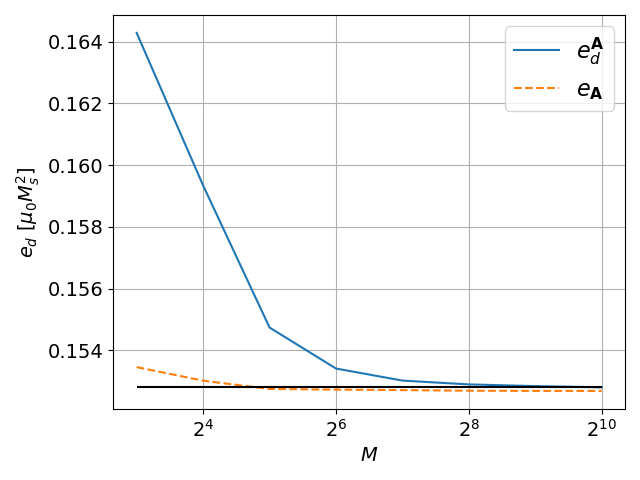

In [44]:
fig = plt.figure()
plt.plot([2 ** i for i in range(3, 11)], energies_A, label=r"$e_d^{\mathbf{A}}$")
plt.plot([2 ** i for i in range(3, 11)], upper_bounds, "--", label=r"$e_{\mathbf{A}}$")
plt.hlines(e_true, 2 ** 3, 2 ** 10, "black")
plt.ylabel("$e_d$ $[\mu_0 M_s^2]$", fontsize=14)
plt.xlabel("$M$", fontsize=14)
plt.xscale("log", base=2)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=14)
plt.grid()
plt.legend(fontsize=16)
plt.tight_layout()
fig.savefig("cube_elm_vec_pot.pdf")

## Computation of the self-energy for the vortex state using the vector potential

We perform the same computation with the vector potential for the vortex state.
The function `solve_vec_pot` is redefined because it used an ELM with a RBF basis,
since this basis is the better choice to capture the complex solution of $A_1$.

In [45]:
e_true = 0.0438 / 2

def solve_vec_pot(mag, W_elm):
    h_elm = lambda x: exp(-10.0 * norm(W_elm - x, axis=-1) ** 2)
    u_elm = lambda x: h_elm(x) * adf(x)
    Q_A1 = vmap(lambda x: laplace(u_elm)(x))(X)
    U_A1, S_A1, VT_A1 = jax.scipy.linalg.svd(
        Q_A1, full_matrices=False, lapack_driver="gesvd"
    )
    #S_phi1 = S_phi1 + 1e-2
    S_A1_inv = S_A1 / (S_A1 ** 2 + 1e-3)#jnp.where(S_phi1 > 1e-5, 1 / S_phi1, 0.0)
    Pinv_A1 = VT_A1.T * S_A1_inv @ U_A1.T
    
    b1 = vmap(lambda x: -curl(mag)(x))(X)
    params_A1 = Pinv_A1 @ b1
    A1 = lambda x: u_elm(x) @ params_A1
    A1_without_adf = lambda x: h_elm(x) @ params_A1
        
    g = vector_potential_charge(adf, mag, A1_without_adf, normalized=True)
    c = compute_charge(g, params_mag=(), params_A1=())
    return A1, c


energies_A = []
upper_bounds = []
for i in range(3, 11):
    _weights = array(Halton(3, seed=42).random(2 ** i))
    W_elm = cube.transform(_weights)
    # here we insert the magnetization for the vortex state
    A1, c = solve_vec_pot(m_vortex, W_elm)
    e, l = energy_and_upper_bound(m_vortex, A1, c)  
    
    error = jnp.abs(e - e_true)
    energies_A.append(e)
    upper_bounds.append(l)
    print(f"Number of basis functions {2 ** i}, energy: {e}, upper bound: {l}, error: {error}")

Number of basis functions 8, energy: 0.23486405611038208, upper bound: 0.43282949924468994, error: 0.21296405792236328
Number of basis functions 16, energy: 0.1454305350780487, upper bound: 0.17639349400997162, error: 0.12353053689002991
Number of basis functions 32, energy: 0.09017357230186462, upper bound: 0.08757807314395905, error: 0.06827357411384583
Number of basis functions 64, energy: 0.050914280116558075, upper bound: 0.04205333814024925, error: 0.029014280065894127
Number of basis functions 128, energy: 0.032812073826789856, upper bound: 0.027577415108680725, error: 0.010912073776125908
Number of basis functions 256, energy: 0.025325898081064224, upper bound: 0.024153681471943855, error: 0.003425898030400276
Number of basis functions 512, energy: 0.024043340235948563, upper bound: 0.02312001958489418, error: 0.0021433401852846146
Number of basis functions 1024, energy: 0.023736072704195976, upper bound: 0.022917533293366432, error: 0.0018360726535320282


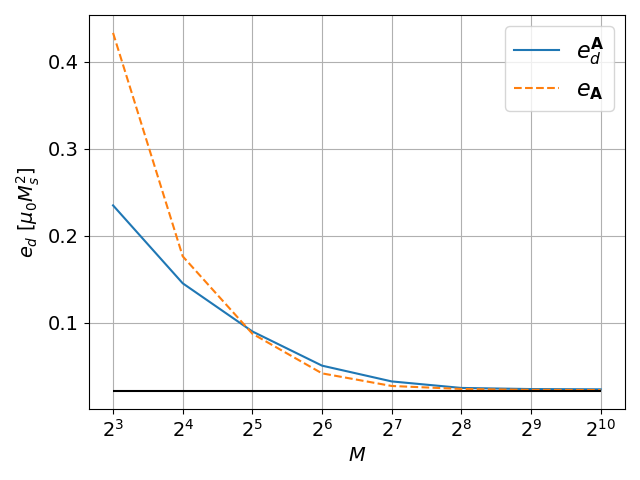

In [46]:
fig = plt.figure()
plt.plot([2 ** i for i in range(3, 11)], energies_A, label=r"$e_d^{\mathbf{A}}$")
plt.plot([2 ** i for i in range(3, 11)], upper_bounds, "--", label=r"$e_{\mathbf{A}}$")
plt.hlines(e_true, 2 ** 3, 2 ** 10, "black")
plt.ylabel("$e_d$ $[\mu_0 M_s^2]$", fontsize=14)
plt.xlabel("$M$", fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=14)
plt.xscale("log", base=2)
plt.grid()
plt.legend(fontsize=16)
plt.tight_layout()
fig.savefig("cube_elm_vec_pot_vortex.pdf")

## Computation of $\phi_1$ via a PINN

Here we use a PINN instead of an ELM for the computation of $\phi_1$. This is done for illustration, and it can also be seen that the lower bound might yield
a nice metric for the evaluation of the final model.

In [21]:
key = random.key(1)
m_init = lambda x: zeros_like(x).at[..., -1].set(1.0)

class Phi1Model(nn.Module):
    @nn.compact
    def __call__(self, x):
        nodes = 16
        activation = nn.gelu
        y = activation(nn.Dense(nodes, name="dense1", kernel_init=nn.initializers.he_normal())(x))
        y = activation(nn.Dense(nodes, name="dense2", kernel_init=nn.initializers.he_normal())(y))
        y = nn.Dense(1, name="dense4", kernel_init=nn.initializers.he_normal())(y)
        return y[0]
    
key, _k = random.split(key)
phi1_model = Phi1Model()
init_params = phi1_model.init(_k, zeros((3,)))


def phi1(x, params):
    return phi1_model.apply(params, x)

def solve_phi12(phi1, params_phi1=()):
    charge_fn = scalar_potential_charge(adf, m_flower, phi1, normalized=True)
    c = compute_charge(charge_fn, params_mag=(), params_phi1=params_phi1)
    
    def solve(z, grad_z):
        phi2 = single_layer_potential(z, c)
        Jphi2 = single_layer_potential(grad_z, c)
        return phi2, Jphi2
    
    return solve

def mag_energy(x_z_dz, phi1, phi2_Jphi2):
    x, z, dz = x_z_dz
    m = lambda x: m_flower(x)
    Jphi1 = jacfwd(phi1)(x)
    phi2, Jphi2 = phi2_Jphi2(z, dz)
    
    h = - (Jphi1 + Jphi2)
    lower_bound = -jnp.sum(Jphi1 * Jphi1) - 2 * m(x) @ h - (divergence(m)(x) * phi2 + m(x) @ Jphi2 - laplace(phi1)(x) * phi2)

    return 1 / 2 * (- (m(x) @ h)), 1 / 2 * lower_bound

@jit
def loss(params, X, X_val, Z_val, dZ_val):
    _phi1 = lambda x: adf(x) * phi1(x, params)
    loss = lambda x: norm(laplace(_phi1)(x) - divergence(m_flower)(x)) ** 2
    
    phi2_Jphi2 = solve_phi12(phi1, (params,))
    energy, lower_bound = mc_integrate(mag_energy, (X_val, Z_val, dZ_val), _phi1, phi2_Jphi2)
    return mc_integrate(loss, X), {"ed": energy, "lower_bound": lower_bound}

In [22]:
# The TR algorithm can take a callback to capture intermediate results
states_phi = []
def cb_phi(step):
    states_phi.append(step[1])
    
solver = TR(loss, has_aux=True, maxiter=1000, tol=1e-4, damping_factor=1e-3, unroll=False, callback=cb_phi, implicit_diff=False)
params, state = solver.run(init_params, X, X_val, Z_val, dZ_val)

In [23]:
# Final result
states_phi[-1].aux

{'ed': Array(0.15246914, dtype=float32),
 'lower_bound': Array(0.15256688, dtype=float32)}

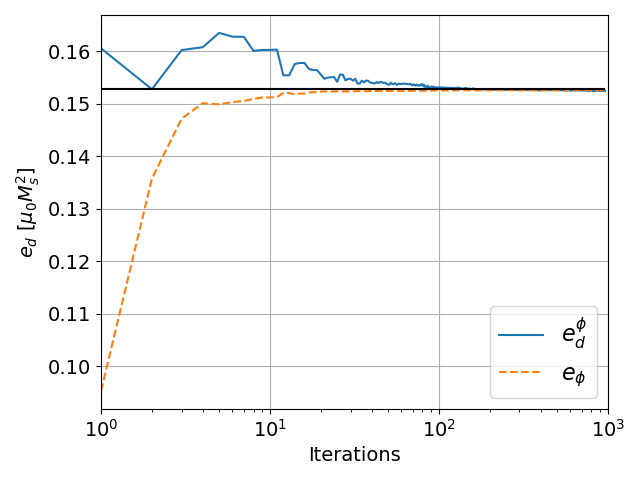

In [24]:
_energies_phi = asarray([s.aux["ed"] for s in states_phi])
_lower_bounds = asarray([s.aux["lower_bound"] for s in states_phi])

fig = plt.figure()
plt.plot(range(1, len(_energies_phi) + 1), _energies_phi, label=r"$e_d^{\phi}$")
plt.plot(range(1, len(_lower_bounds) + 1), _lower_bounds, "--", label=r"$e_\phi$")
plt.hlines(0.1528, 0, len(_energies_phi) - 1, "black")
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=14)
plt.ylabel("$e_d$ $[\mu_0 M_s^2]$", fontsize=14)
plt.xlabel("Iterations", fontsize=14)
plt.xscale("log")
plt.xlim((1, 1000))

plt.grid()
plt.legend(fontsize=16)
plt.tight_layout()
fig.savefig("cube_pinn_scalar_pot.pdf")

## Computation of $A_1$ via a PINN

In [30]:
key = random.key(1)
m_init = lambda x: zeros_like(x).at[..., -1].set(1.0)

class A1Model(nn.Module):
    @nn.compact
    def __call__(self, x):
        nodes = 16
        activation = nn.gelu
        y = activation(nn.Dense(nodes, name="dense1", kernel_init=nn.initializers.he_normal())(x))
        y = activation(nn.Dense(nodes, name="dense2", kernel_init=nn.initializers.he_normal())(y))
        y = nn.Dense(3, name="dense4", kernel_init=nn.initializers.he_normal())(y)
        return y
    
key, _k = random.split(key)
A1_model = A1Model()
init_params = A1_model.init(_k, zeros((3,)))


def A1(x, params):
    return A1_model.apply(params, x)

def solve_A2(A1, params_A1=()):
    charge_fn = vector_potential_charge(adf, m_flower, A1, normalized=True)
    c = compute_charge(charge_fn, params_mag=(), params_A1=params_A1)
    
    def solve(z, grad_z):
        A2 = single_layer_potential(z, c)
        curlA2 = curl_single_layer_potential(grad_z, c)
        return A2, curlA2
    
    return solve

def mag_energy(x_z_dz, A1, A2_curlA2):
    x, z, dz = x_z_dz
    m = lambda x: m_flower(x)
    JA1 = jacfwd(A1)(x)
    curlA1 = curl(A1)(x)
    A2, curlA2 = A2_curlA2(z, dz)
    _curlA = curlA1 + curlA2
    upper_bound = norm(m(x)) ** 2 + jnp.sum(JA1 * JA1) - 2 * m(x) @ _curlA - curl(m)(x) @ A2 + m(x) @ curlA2 - laplace(A1)(x) @ A2
    return 1 / 2 * (1 - (m(x) @ _curlA)), 1 / 2 * upper_bound

@jit
def loss(params, X, X_val, Z_val, dZ_val):
    _A1 = lambda x: adf(x) * A1(x, params)
    loss = lambda x: norm(laplace(_A1)(x) + curl(m_flower)(x)) ** 2
    
    A2_curlA2 = solve_A2(A1, (params,))
    energy, upper_bound = mc_integrate(mag_energy, (X_val, Z_val, dZ_val), _A1, A2_curlA2)
    return mc_integrate(loss, X), {"ed": energy, "upper_bound": upper_bound}

In [31]:
states_A = []
def cb_A(step):
    states_A.append(step[1])
    
solver = TR(loss, has_aux=True, maxiter=1000, tol=1e-3, damping_factor=1e-3, unroll=False, callback=cb_A, implicit_diff=False)
params, state = solver.run(init_params, X, X_val, Z_val, dZ_val)

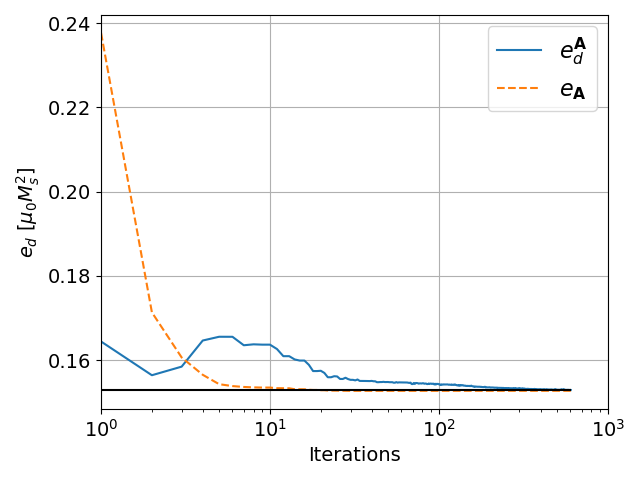

In [33]:
_energies_A = asarray([s.aux["ed"] for s in states_A])
_upper_bounds = asarray([s.aux["upper_bound"] for s in states_A])

fig = plt.figure()
plt.plot(range(1, len(_energies_A) + 1), _energies_A, label=r"$e_d^{\mathbf{A}}$")
plt.plot(range(1, len(_upper_bounds) + 1), _upper_bounds, "--", label=r"$e_{\mathbf{A}}$")
plt.hlines(0.1528, 0, len(_energies_A) - 1, "black")
plt.ylabel(r"$e_d$ $[\mu_0 M_s^2]$", fontsize=14)
plt.xlabel("Iterations", fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=14)
plt.xscale("log")
plt.xlim((1, 1000))

plt.grid()
plt.legend(fontsize=16)
plt.tight_layout()
fig.savefig("cube_pinn_vec_pot.pdf")

In [34]:
print(f"e scalar pot: {_energies_phi[-1]}, e vec pot: {_energies_A[-1]}, lb: {_lower_bounds[-1]}, ub: {_upper_bounds[-1]}")

e scalar pot: 0.15246914327144623, e vec pot: 0.15293093025684357, lb: 0.15256687998771667, ub: 0.15272873640060425
